### refs usadas:
- https://www.researchgate.net/publication/324929106_Dynamic_Models_of_a_Home_Refrigerator
- http://www.ingaero.uniroma1.it/attachments/2176_Cap_3%20Thermal-electrical%20analogy.pdf
- https://www.engineeringtoolbox.com/heat-work-energy-d_292.html
- https://economizandoenergia.wordpress.com/2011/12/11/hackeando-a-geladeira/

### refs não usadas, mas interessantes:
- https://www.researchgate.net/publication/269930557_Temperature_control_in_a_cavity_of_refrigeration_using_PI_controller_and_predictive_control
- http://greenteapress.com/modsimpy/ModSimPy3.pdf


#### Breve revisão de calor no ponto de vista energético:
- Para aquecer um corpo de massa $m$ de calor específico $c_p$ em diferença de temperatura $dT$ é necessário o calor $Q$ (em _Joules_), de modo que:
$$ Q = c_p\,m\,dT $$
- A potência (em _Watts_) necessária para aquecer o mesmo corpo em um intervalo de tempo $t$ é:
$$ q = Q / t $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_freezer_unit(sensor_id: int, verbose=False):
    """ consumo médio de um congelador:
    ref:  http://www.procelinfo.com.br/services/DocumentManagement/FileDownload.EZTSvc.asp?DocumentID={8898769E-E9B6-4AB9-A509-CCAFE715310F}&ServiceInstUID={46764F02-4164-4748-9A41-C8E7309F80E1}
    modelo: RCFB32
    compartimento: 385 Litros
    consumo: 35.9 kwh/mês

    ref:  https://www.mideastore.com.br/media/productattach/m/a/manual_do_usu_rio_3.pdf
    Corrente nominal de operação em 220V: 1.6A
    
    # Parece ok, resultados proximos de: https://economizandoenergia.wordpress.com/tag/freezer/
    """
    E_monthly = 35.9e3 * (0.95 + 0.05 * np.random.rand()) # adicionando uma variação para as unidades
    E_anualy = E_monthly * 12
    hours_per_year = 8760
    E_hourly = E_anualy / hours_per_year
    E_daily = E_hourly * 24
    E_minutely = E_hourly / 60
    E_secondly = E_minutely / 60
    # print(E_anualy, E_monthly, E_daily, E_hourly, E_minutely, E_secondly)

    # Estimativas para fechar com os dados de catálogo:
    I_nominal = 1.6 * (0.8 + 0.2 * np.random.rand()) # adicionando uma variação para as unidades
    P_nominal = 220 * I_nominal
    P_nominal_avg = 250
    on_to_off_factor = P_nominal_avg / P_nominal
    P_on = 220 * I_nominal * on_to_off_factor 
    P_off = 220 * I_nominal * (1 - on_to_off_factor)
    if verbose:
        print(f"P nominal = {P_nominal} W")
        print(f"Pon = {P_on} W")
        print(f"Poff = {P_off} W")
        print(f"Check: {P_nominal == P_on + P_off}")

    t_daily = 24.0
    P_daily = E_daily / t_daily
    t_on = t_daily * (P_daily - P_off) / (P_off - P_on)
    t_off = t_daily - t_on
    duty_cycle = t_on / t_daily
    if verbose:
        print(f"daily total: P = {P_daily} W, t = {t_daily} h")
        print(f"daily on: P = {P_on} W, t = {t_on} h")
        print(f"daily off: P = {P_off} W, t = {t_off} h")
        print(f"duty cycle: {duty_cycle * 100} %")
        print(f"Check: {t_daily == t_on + t_off}")
        
    return {
        'sensor_id': sensor_id,
        'model': 'RCFB32',
        'volume': 385,
        'E_monthly': E_monthly,
        'E_anualy': E_anualy,
        'E_hourly': E_hourly,
        'E_daily': E_daily,
        'E_minutely': E_minutely,
        'E_secondly': E_secondly,
        'I_nominal': I_nominal,
        'P_nominal': P_nominal,
        'P_nominal_avg': P_nominal_avg,
        'on_to_off_factor': on_to_off_factor,
        'P_on': P_on,
        'P_off': P_off,
        't_daily': t_daily,
        'P_daily': P_daily,
        't_on': t_on,
        't_off': t_off,
        'duty_cycle': duty_cycle,
    }

print("EXAMPLE:\n")
example = generate_freezer_unit(0,verbose=True)
display(example)

EXAMPLE:

P nominal = 346.68028054478367 W
Pon = 249.99999999999997 W
Poff = 96.68028054478368 W
Check: True
daily total: P = 46.96571461826744 W, t = 24.0 h
daily on: P = 249.99999999999997 W, t = 7.782101261833455 h
daily off: P = 96.68028054478368 W, t = 16.217898738166546 h
duty cycle: 32.425421924306065 %
Check: True


{'sensor_id': 0,
 'model': 'RCFB32',
 'volume': 385,
 'E_monthly': 34284.97167133523,
 'E_anualy': 411419.6600560228,
 'E_hourly': 46.96571461826744,
 'E_daily': 1127.1771508384186,
 'E_minutely': 0.7827619103044573,
 'E_secondly': 0.013046031838407622,
 'I_nominal': 1.5758194570217439,
 'P_nominal': 346.68028054478367,
 'P_nominal_avg': 250,
 'on_to_off_factor': 0.7211255269758712,
 'P_on': 249.99999999999997,
 'P_off': 96.68028054478368,
 't_daily': 24.0,
 'P_daily': 46.96571461826744,
 't_on': 7.782101261833455,
 't_off': 16.217898738166546,
 'duty_cycle': 0.32425421924306064}

# Abrindo banco de dados de temperaturas de florianópolis

,ta
timestamp,
2019-01-01 01:00:00,26.9
2019-01-01 02:00:00,26.6
2019-01-01 03:00:00,26.4
2019-01-01 04:00:00,26.5
2019-01-01 05:00:00,26.5
...,...
2019-12-31 19:00:00,29.3
2019-12-31 20:00:00,28.0
2019-12-31 21:00:00,27.2


,ta
count,8751.000000
mean,21.815987
std,4.298974
min,5.100000
25%,19.200000
50%,21.900000
75%,24.600000
max,39.300000


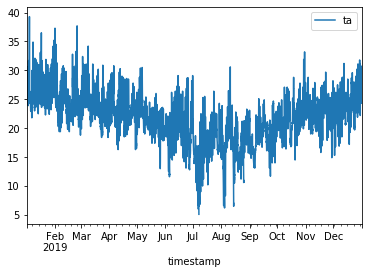

In [2]:
ta_df = pd.read_csv(
    'data/ambient_temperature_hourly.csv',
    header=10,
    date_parser=pd.to_datetime,
    names=['timestamp', 'ta'],
    index_col='timestamp',
)
display(ta_df)
display(ta_df.describe())
ta_df.plot()

Função para plotar multiplos gráficos com eixos diferentes

In [3]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):
    """ https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes """
    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
#     colors = plotting._style._get_standard_colors(num_colors=len(cols))
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

# from random import randrange

# data = pd.DataFrame(dict(
#     s1=[randrange(-1000, 1000) for _ in range(100)],
#     s2=[randrange(-100, 100) for _ in range(100)],
#     s3=[randrange(-10, 10) for _ in range(100)],
# ))

# plot_multi(data.cumsum(), figsize=(10, 5))

# Gerando os dados do sensor

,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.038577,110.617222,38.577426,220.073383,0.175300,5.402968
std,4.298974,0.009437,58.494148,9.437038,1.443839,0.042891,1.630851
min,5.100000,0.008278,0.030781,8.277786,217.511927,0.037834,1.238130
25%,19.200000,0.031980,62.547751,31.979906,218.824970,0.145413,4.068209
50%,21.900000,0.038032,114.805871,38.031837,220.066809,0.172955,5.642782
75%,24.600000,0.044720,157.852243,44.720176,221.343886,0.203170,6.559948
max,39.300000,0.077310,213.522125,77.310427,222.587860,0.353300,8.801091


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.048666,0.030781,48.666483,218.767802,0.222457,7.869819
1546308000000,26.6,0.048935,0.061732,48.935295,222.300019,0.220132,8.420934
1546311600000,26.4,0.057762,0.098266,57.762058,219.185720,0.263530,8.192296
1546315200000,26.5,0.039603,0.123314,39.602769,218.179496,0.181515,8.456815
1546318800000,26.5,0.046744,0.152879,46.743591,218.092682,0.214329,8.423013


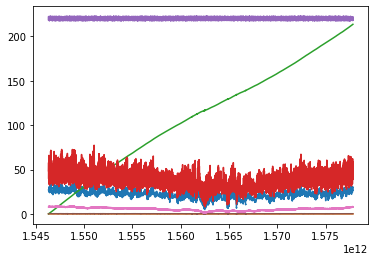

Done: the data for the sensor id 0 was saved to: data/0_sensor_0_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.039023,111.894762,39.022901,220.072835,0.177331,5.404587
std,4.298974,0.009598,59.234037,9.597770,1.444247,0.043655,1.624258
min,5.100000,0.007213,0.037054,7.213182,217.512697,0.032543,1.215162
25%,19.200000,0.032419,63.161957,32.418921,218.834104,0.147109,4.114975
50%,21.900000,0.038546,116.314819,38.545700,220.081846,0.175181,5.658691
75%,24.600000,0.045227,159.732193,45.226686,221.351533,0.205427,6.530264
max,39.300000,0.081425,215.987781,81.425031,222.599501,0.371027,8.791227


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.058584,0.037054,58.584313,218.751950,0.267812,8.033065
1546308000000,26.6,0.048585,0.067783,48.584949,222.253777,0.218601,7.930376
1546311600000,26.4,0.038740,0.092286,38.740186,219.150063,0.176775,8.416909
1546315200000,26.5,0.055671,0.127497,55.670674,218.235114,0.255095,7.719618
1546318800000,26.5,0.043446,0.154976,43.445556,218.101906,0.199198,7.629461


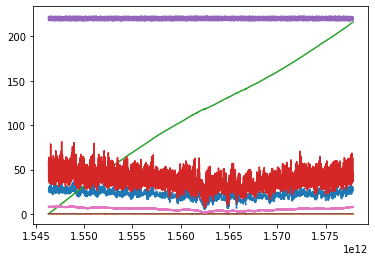

Done: the data for the sensor id 1 was saved to: data/0_sensor_1_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.038459,110.298770,38.458614,220.073340,0.174761,5.404104
std,4.298974,0.009460,58.318624,9.460306,1.444282,0.042998,1.631243
min,5.100000,0.007754,0.023701,7.754320,217.506948,0.034985,1.250926
25%,19.200000,0.031889,62.407286,31.889240,218.828973,0.145042,4.085140
50%,21.900000,0.037869,114.616373,37.869085,220.080918,0.172072,5.639582
75%,24.600000,0.044638,157.394853,44.637569,221.348733,0.202801,6.554896
max,39.300000,0.075725,212.864512,75.725383,222.589121,0.343542,8.832486


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.037473,0.023701,37.472599,218.784732,0.171276,7.897279
1546308000000,26.6,0.043854,0.051438,43.853632,222.215488,0.197347,7.953460
1546311600000,26.4,0.057331,0.087699,57.330520,219.191193,0.261555,7.688034
1546315200000,26.5,0.048722,0.118514,48.721554,218.168817,0.223320,7.926228
1546318800000,26.5,0.048357,0.149099,48.356687,218.020017,0.221799,8.041555


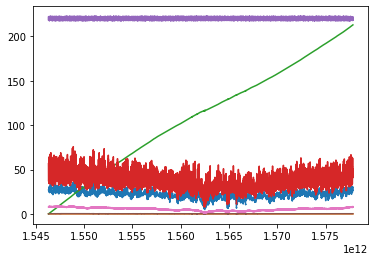

Done: the data for the sensor id 2 was saved to: data/0_sensor_2_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.038914,111.365290,38.913929,220.073264,0.176835,5.403091
std,4.298974,0.009612,59.087035,9.611564,1.444070,0.043711,1.627726
min,5.100000,0.007733,0.028217,7.732845,217.513941,0.035347,1.261060
25%,19.200000,0.032299,62.684353,32.299469,218.834275,0.146822,4.092576
50%,21.900000,0.038275,115.799050,38.275406,220.070694,0.174060,5.642338
75%,24.600000,0.045188,158.987344,45.188435,221.345542,0.205381,6.546541
max,39.300000,0.085076,215.384630,85.076221,222.585408,0.382220,8.823547


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.044613,0.028217,44.612963,218.746677,0.203948,8.297337
1546308000000,26.6,0.055201,0.063131,55.200986,222.223741,0.248403,7.990205
1546311600000,26.4,0.043229,0.090473,43.229313,219.105738,0.197299,8.242703
1546315200000,26.5,0.045976,0.119552,45.976045,218.162719,0.210742,8.290278
1546318800000,26.5,0.057006,0.155608,57.005982,218.027602,0.261462,8.520111


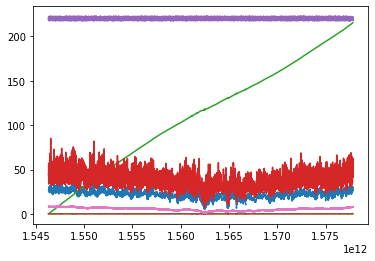

Done: the data for the sensor id 3 was saved to: data/0_sensor_3_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037541,107.507170,37.541052,220.073109,0.170594,5.402604
std,4.298974,0.009244,56.904836,9.243567,1.443634,0.042030,1.630905
min,5.100000,0.009334,0.025077,9.333611,217.508980,0.042105,1.210284
25%,19.200000,0.031140,60.740661,31.139629,218.839165,0.141512,4.126451
50%,21.900000,0.036951,111.694273,36.951150,220.075130,0.167903,5.615853
75%,24.600000,0.043454,153.321777,43.453688,221.342736,0.197364,6.540167
max,39.300000,0.073357,207.785899,73.356561,222.585814,0.332777,8.794660


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.039648,0.025077,39.648374,218.720246,0.181274,8.437466
1546308000000,26.6,0.045262,0.053705,45.262407,222.212381,0.203690,8.194779
1546311600000,26.4,0.041093,0.079696,41.092679,219.184152,0.187480,7.738277
1546315200000,26.5,0.052780,0.113078,52.779973,218.155399,0.241938,7.739138
1546318800000,26.5,0.042461,0.139934,42.460646,218.100742,0.194684,8.211149


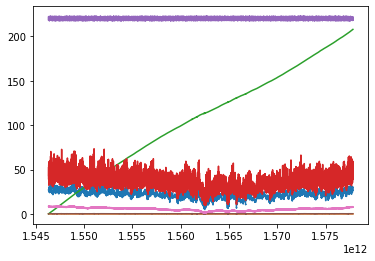

Done: the data for the sensor id 4 was saved to: data/0_sensor_4_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037792,108.381148,37.791738,220.072986,0.171732,5.404618
std,4.298974,0.009325,57.324489,9.324572,1.444173,0.042391,1.631768
min,5.100000,0.007629,0.031047,7.628543,217.505300,0.034417,1.227545
25%,19.200000,0.031176,61.227537,31.175694,218.831226,0.141478,4.081262
50%,21.900000,0.037267,112.703083,37.267105,220.078604,0.169321,5.639103
75%,24.600000,0.043956,154.666344,43.955830,221.346709,0.199705,6.562694
max,39.300000,0.082074,209.173417,82.073670,222.595115,0.373501,8.819589


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.049087,0.031047,49.086655,218.762716,0.224383,8.199044
1546308000000,26.6,0.039019,0.055726,39.018735,222.291045,0.175530,8.137992
1546311600000,26.4,0.034421,0.077496,34.420908,219.119579,0.157087,7.798518
1546315200000,26.5,0.035053,0.099667,35.052555,218.244079,0.160612,8.074229
1546318800000,26.5,0.054155,0.133919,54.154837,218.014575,0.248400,7.654923


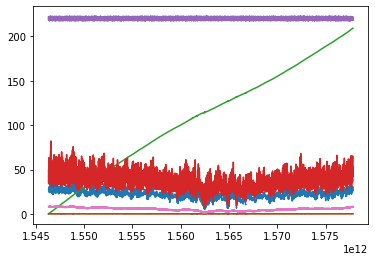

Done: the data for the sensor id 5 was saved to: data/0_sensor_5_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.039086,112.020130,39.085811,220.073316,0.177613,5.407166
std,4.298974,0.009557,59.352102,9.557115,1.444024,0.043449,1.627162
min,5.100000,0.007693,0.023395,7.692970,217.507170,0.034711,1.212169
25%,19.200000,0.032432,63.270249,32.432056,218.833571,0.147300,4.126617
50%,21.900000,0.038478,116.319932,38.477690,220.078623,0.174942,5.628628
75%,24.600000,0.045294,160.055772,45.293921,221.346495,0.205653,6.552564
max,39.300000,0.088147,216.335983,88.147224,222.589581,0.401043,8.810919


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.036988,0.023395,36.988482,218.774165,0.169072,7.912899
1546308000000,26.6,0.036071,0.046209,36.070666,222.236761,0.162307,7.660395
1546311600000,26.4,0.046828,0.075827,46.828377,219.145243,0.213686,8.425919
1546315200000,26.5,0.048843,0.106720,48.843084,218.211329,0.223834,8.436228
1546318800000,26.5,0.056601,0.142520,56.601432,218.102440,0.259518,8.294639


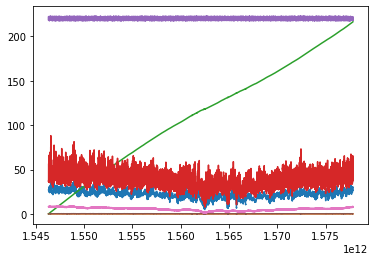

Done: the data for the sensor id 6 was saved to: data/0_sensor_6_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.038829,111.325753,38.828760,220.073026,0.176446,5.406817
std,4.298974,0.009574,58.882612,9.573829,1.444341,0.043531,1.628616
min,5.100000,0.007878,0.022740,7.878051,217.513435,0.035534,1.215798
25%,19.200000,0.032102,62.911309,32.102058,218.828693,0.145717,4.114566
50%,21.900000,0.038228,115.699025,38.227505,220.072135,0.173680,5.644105
75%,24.600000,0.045082,158.859144,45.082139,221.347207,0.204738,6.539913
max,39.300000,0.080757,214.913229,80.756627,222.586878,0.362911,8.826846


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.035953,0.022740,35.952937,218.717145,0.164381,7.748425
1546308000000,26.6,0.041215,0.048808,41.215228,222.229020,0.185463,7.716886
1546311600000,26.4,0.056030,0.084246,56.029849,219.175344,0.255639,8.455094
1546315200000,26.5,0.035751,0.106858,35.751201,218.246822,0.163811,8.504460
1546318800000,26.5,0.044779,0.135181,44.779323,218.022960,0.205388,8.100058


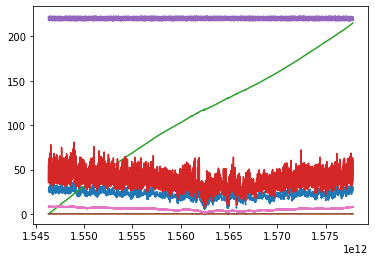

Done: the data for the sensor id 7 was saved to: data/0_sensor_7_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.038780,110.995332,38.780253,220.073659,0.176222,5.404952
std,4.298974,0.009560,58.853184,9.559732,1.443962,0.043452,1.630932
min,5.100000,0.007518,0.026824,7.517590,217.504160,0.033915,1.238414
25%,19.200000,0.032157,62.445906,32.157008,218.829772,0.146187,4.092202
50%,21.900000,0.038201,115.390469,38.200573,220.075748,0.173598,5.653405
75%,24.600000,0.044929,158.441633,44.928520,221.343186,0.204324,6.566591
max,39.300000,0.086980,214.644748,86.979599,222.596891,0.390902,8.746600


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.042410,0.026824,42.410253,218.743782,0.193881,8.041227
1546308000000,26.6,0.046826,0.056441,46.826401,222.304511,0.210641,7.639325
1546311600000,26.4,0.049518,0.087760,49.517619,219.098894,0.226006,7.936806
1546315200000,26.5,0.045403,0.116477,45.403306,218.245343,0.208038,8.010953
1546318800000,26.5,0.035933,0.139205,35.933497,218.110167,0.164749,7.702637


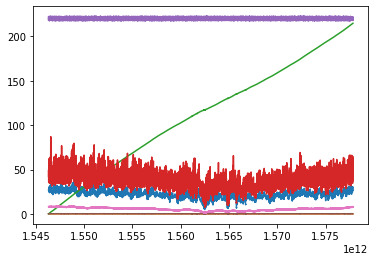

Done: the data for the sensor id 8 was saved to: data/0_sensor_8_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037692,108.094812,37.692352,220.072413,0.171280,5.397814
std,4.298974,0.009267,57.196233,9.267240,1.444139,0.042129,1.631472
min,5.100000,0.008867,0.030131,8.866773,217.507823,0.040128,1.248071
25%,19.200000,0.031224,60.950123,31.223858,218.838603,0.142007,4.094591
50%,21.900000,0.037181,112.328095,37.181309,220.075523,0.168954,5.629425
75%,24.600000,0.043661,154.186786,43.660808,221.344030,0.198583,6.543211
max,39.300000,0.080498,208.623327,80.497727,222.593348,0.361791,8.786093


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.047639,0.030131,47.639449,218.707311,0.217823,8.596895
1546308000000,26.6,0.048629,0.060888,48.628758,222.277240,0.218775,8.305827
1546311600000,26.4,0.041929,0.087408,41.928811,219.130307,0.191342,8.617657
1546315200000,26.5,0.036608,0.110562,36.608316,218.226347,0.167754,7.916971
1546318800000,26.5,0.045780,0.139517,45.779737,218.018677,0.209981,8.315945


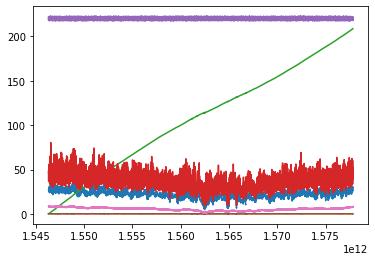

Done: the data for the sensor id 9 was saved to: data/0_sensor_9_db.csv


In [7]:
voltage = 220 + (np.random.rand(len(ta_df)) * 5 - 2.5)
basic_energy_tariff = 0.50599 * (1 + 0.25)  # Tarifa residencial B da celesc + aliquota: 12% se menor que 150kWh, 25% se maior.

def generate_sensor_dataframe(df, sensor: dict, verbose=False, plot=False):
    df['E'] = (0.6 + 0.4*np.random.rand(len(df))) * sensor['E_hourly'] * df['ta'] / df['ta'].mean() / 1000 # kwh
    df['cost'] = df['E'].cumsum() * basic_energy_tariff
    df['P'] = 1000 * df['E'] / 1 # watts
    df['V'] = voltage + 0.1 * np.random.rand(len(df))
    df['I'] = df['P'] / df['V']
    df['ti'] = 4 + np.random.rand(len(df)) + 0.5*df['ta'].rolling(500, win_type='blackman', center=True, min_periods=1).mean() -10
    
    # Convert to epoch in ms
    df.index = (df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
    
    df = df.rename(columns={
        "ta": "ambiente_temperature",
        "ti": "internal_temperature",
        "V": "voltage",
        "I": "current",
        "P": "active_power",
        "E": "energy",
        "cost": "cost",
    })
    if verbose:
        display(df.describe())
        display(df.head())
    if plot:
        plt.Figure(figsize=(20, 10))
        plt.plot(df.rolling(1, win_type='blackman', center=True, min_periods=1).mean())
#         plot_multi(df.rolling(25, win_type='blackman', center=True, min_periods=1).mean())
        plt.show()
    
    output_filename = f"data/0_sensor_{int(sensor['sensor_id'])}_db.csv"
#     df.to_csv(output_filename)
    print(f"Done: the data for the sensor id {sensor['sensor_id']} was saved to: {output_filename}")
    del df


for sensor_id in [0,1,2,3,4,5,6,7,8,9]:
    sensor = generate_freezer_unit(sensor_id)
    generate_sensor_dataframe(ta_df.copy(), sensor, verbose=True, plot=True)